c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Analytic posterior = Beta(3, 4)


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\rich\live.py:260: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_500 tune and 3_000 draw iterations (3_000 + 6_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


MCMC mean     = 0.421939
Analytic mean = 0.428571
MCMC 95% HDI  = [0.097851, 0.750967]
Analytic 95% CI (Beta quantile) = [0.118117, 0.777222]


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24403 (\N{CJK UNIFIED IDEOGRAPH-5F53}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12383 (\N{HIRAGANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{C

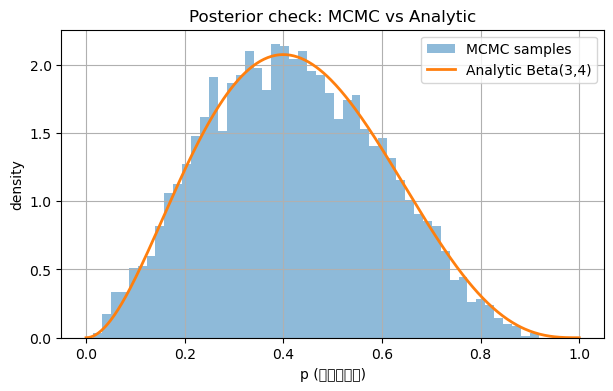

    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.422  0.175   0.099    0.731      0.004    0.002    1753.0    1851.0   

   r_hat  
p    1.0  


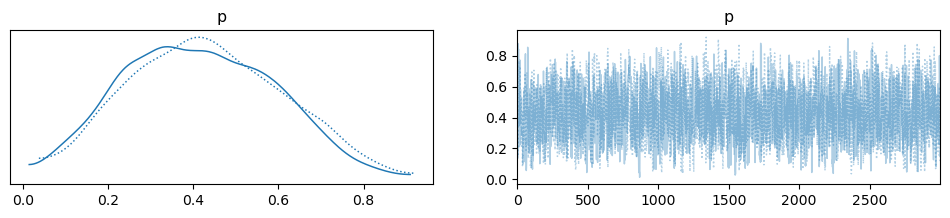

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
from scipy.stats import beta as sp_beta

# 観測データ（当たり=1, はずれ=0）
data = np.array([1, 0, 0, 1, 0], dtype=int)
k = int(data.sum())
n = int(len(data))

# 解析解（事前 Beta(1,1)）
alpha_prior, beta_prior = 1, 1
alpha_post = alpha_prior + k
beta_post  = beta_prior + (n - k)

print(f"Analytic posterior = Beta({alpha_post}, {beta_post})")

with pm.Model() as model:
    p = pm.Beta("p", alpha=alpha_prior, beta=beta_prior)
    y = pm.Bernoulli("y", p=p, observed=data)

    # MCMC（NUTS）
    trace = pm.sample(
        draws=3000,
        tune=1500,
        chains=2,
        target_accept=0.95,
        random_seed=42,
        progressbar=True
    )

# --- 数値比較（平均・HDI） ---
p_samples = trace.posterior["p"].values.reshape(-1)

mcmc_mean = float(p_samples.mean())
analytic_mean = alpha_post / (alpha_post + beta_post)

hdi = az.hdi(p_samples, hdi_prob=0.95)
print(f"MCMC mean     = {mcmc_mean:.6f}")
print(f"Analytic mean = {analytic_mean:.6f}")
print(f"MCMC 95% HDI  = [{float(hdi[0]):.6f}, {float(hdi[1]):.6f}]")
print(f"Analytic 95% CI (Beta quantile) = [{sp_beta.ppf(0.025, alpha_post, beta_post):.6f}, {sp_beta.ppf(0.975, alpha_post, beta_post):.6f}]")

# --- 図：MCMCヒストグラム vs 解析Beta密度 ---
x = np.linspace(0, 1, 400)
pdf = sp_beta.pdf(x, alpha_post, beta_post)

plt.figure(figsize=(7,4))
plt.hist(p_samples, bins=50, density=True, alpha=0.5, label="MCMC samples")
plt.plot(x, pdf, linewidth=2, label=f"Analytic Beta({alpha_post},{beta_post})")
plt.xlabel("p (当たり確率)")
plt.ylabel("density")
plt.title("Posterior check: MCMC vs Analytic")
plt.grid(True)
plt.legend()
plt.show()

# --- 追加：収束のざっくり確認（任意） ---
print(az.summary(trace, var_names=["p"]))
az.plot_trace(trace, var_names=["p"])
plt.show()
